<a href="https://colab.research.google.com/github/Abdulsalam-Aderoju/CNN-in-Tensorflow/blob/main/Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Commomly Used Function

This could be done by writng these function in a python file, uploading it to github, convert to raw, and then copy the link and paste on colab to get dowmloaded using the !wget

All function in the python file will then be able to be imported for example:
- from helper_functions (name of python file) import plot_curves (a function in the file)

# Let us get some data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-21 09:16:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: â€˜10_food_classes_10_percent.zipâ€™

10_food_classes_10_ 100%[===================>] 160.74M   213MB/s    in 0.8s    

2022-07-21 09:16:10 (213 MB/s) - â€˜10_food_classes_10_percent.zipâ€™ saved [168546183/168546183]



In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 10 director

In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
for image, label in train_data_10_percent.take(1):
  print(image, label)
  print()

tf.Tensor(
[[[[1.01296562e+02 9.42965622e+01 5.22965546e+01]
   [1.03403061e+02 9.54030609e+01 5.93316345e+01]
   [1.08793365e+02 9.95790787e+01 7.10076523e+01]
   ...
   [2.35086231e+01 2.60172482e+01 1.04913759e+01]
   [2.64241199e+01 2.94241199e+01 1.10790854e+01]
   [2.63481789e+01 2.93481789e+01 1.03481798e+01]]

  [[1.07638718e+02 1.00601410e+02 5.87133293e+01]
   [1.07411354e+02 9.94113541e+01 6.33399239e+01]
   [1.12610970e+02 1.03409119e+02 7.47216263e+01]
   ...
   [1.94955559e+01 2.14955559e+01 7.55359268e+00]
   [2.49729214e+01 2.79190331e+01 1.10807009e+01]
   [2.89046574e+01 3.19046574e+01 1.49046574e+01]]

  [[1.09861603e+02 1.01946106e+02 6.26926041e+01]
   [1.16691010e+02 1.08691010e+02 7.26195831e+01]
   [1.18625000e+02 1.09625000e+02 7.90535736e+01]
   ...
   [1.32589502e+01 1.52589502e+01 2.25895023e+00]
   [2.06875381e+01 2.27044430e+01 9.36258698e+00]
   [2.58303909e+01 2.80669994e+01 1.33571777e+01]]

  ...

  [[2.45249786e+02 2.21776520e+02 1.69303253e+02]
   [2

# Create TensorBoard Callback

The goal is to make us track our experiment and compare our models

In [ ]:
import datetime
def create_tensorboard_callback(dirname, experiment_name):
  log_dir = dirname + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%m%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback



# **Model 0: Bulding A Transfer Learning Feature Extraction Model Using Keras Functional API**

The Sequential API runs our layers in sequential order. However, the functional API give sus more flexibility and makes the model more sophisticated. 

In [ ]:
# 1. Create a baseline model with tf.keras.application (EfficientNet pretrained model)

base_model = tf.keras.applications.EfficientNetB0(include_top = False) # The output layer is the top, which we need to tweak to suit our own problem 


# 2. Freeze the base model (so the underlying pretrained patterns are not updated during training)
    # IMO, I strogly believe the underlying patterns are those learnt from the ImageNet Data.
    # These are beng frozen because it is just the architecture we need.

base_model.trainable = False


# 3> Create inputs int our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'Input_Layer')


# 4. It should be noted that it is quite unusual of us to not have normalized our tensors before building the model.
     # This is due to the fact that the EfficientNet models do not need them. However, the normalization must be done if it is the ResNet models
     # For the Function API, we are able to normalize our data (tensors) while building the model this way:

# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)


# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing through the base model {x.shape}")


# 6. Average pool the outputs of the base model (aggregate all the most important information, reducing the number of computations)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")


# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "Output_Layer")(x)


# 8. Combine the inputs and outputs
model_0 = tf.keras.Model(inputs, outputs)


# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])


# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent, 
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dirname = "transfer_learning",
                                                                          experiment_name = "10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing through the base model (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving Tensorboard log files to: transfer_learning/10_percent_feature_extraction/20220721-09071658394988
Epoch 1/5
24/24 [==============================] - 26s 261ms/step - loss: 1.8206 - accuracy: 0.4667 - val_loss: 1.2915 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 5s 183ms/step - loss: 1.1245 - accuracy: 0.7413 - val_loss: 0.8987 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 4s 147ms/step - loss: 0.8337 - accuracy: 0.8000 - val_loss: 0.7437 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 4s 148ms/step - loss: 0.6887 - accuracy: 0.8533 - val_loss: 0.6671 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 5s 183ms/step - loss: 0.5827 - accuracy: 0.8627 - val_loss: 0.6279 - val_accuracy: 0.8339


In [ ]:
# Evaluate on full data
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6040 - accuracy: 0.8404


[0.6040183305740356, 0.840399980545044]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Summary of the whole model (this will iclude whatever we have added in building the model)
model_0.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 Output_Layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Checking out the model's training curves
import matplotlib.pyplot as plt
import pandas as pd

def model_curves(history):
  epochs = range(len(history.history["loss"]))

  # Losses
  training_loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # Accuracies
  training_acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  # Plotting Losses
  plt.figure()
  plt.plot(epochs, training_loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.legend()

  # Plotting Accuracies
  plt.figure()
  plt.plot(epochs, training_acc, label = 'training_acc')
  plt.plot(epochs, val_acc, label = "val_acc")
  plt.legend()

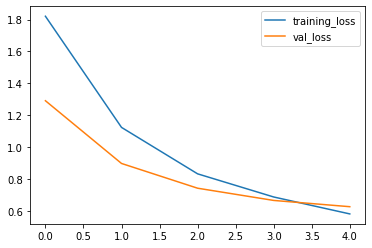

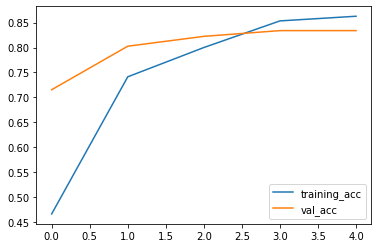

In [ ]:
pd.DataFrame(history_10_percent.history)
model_curves(history_10_percent)

## Getting a feature vector from a trained model
Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through base_model of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280). It essentially converts 4D to 2D

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

ðŸ›  **Practice**: Try to do the same with the above two cells but this time use GlobalMaxPool2D... and see what happens.

ðŸ”‘ **Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of for our own specifc problem.

# Running a series of transfer learning experiments
We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

**model_1 -** use feature extraction transfer learning with 1% of the training data with data augmentation

**model_2 -** use feature extraction transfer learning with 10% of the training with data augmentaton

**model_3 -** use fine-tuning transfer learning on 10% of the training data with data augmentation

**model_4 -** use fine-tuning transfer learning on 100% of the training data with data augmentation



**ðŸ”‘ Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.**

# Model_1: Use Feature Extraction on 1% of the data with data augmentation

## Getting And Preprocessing Data

In [ ]:
# Dowload and unzip data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 

zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-21 09:17:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: â€˜10_food_classes_1_percent.zipâ€™

10_food_classes_1_p 100%[===================>] 127.42M   189MB/s    in 0.7s    

2022-07-21 09:17:21 (189 MB/s) - â€˜10_food_classes_1_percent.zipâ€™ saved [133612354/133612354]



In [ ]:
# Create training and testing dirs
import os
train_dir = "10_food_classes_1_percent/train/"
test_dir = '10_food_classes_1_percent/test/'

# Walkthrough the data
for dirpath, dirname, filename in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirname)}  directories and {len(filename)} images in {dirpath}")

There are 2  directories and 0 images in 10_food_classes_1_percent
There are 10  directories and 0 images in 10_food_classes_1_percent/train
There are 0  directories and 7 images in 10_food_classes_1_percent/train/ramen
There are 0  directories and 7 images in 10_food_classes_1_percent/train/hamburger
There are 0  directories and 7 images in 10_food_classes_1_percent/train/fried_rice
There are 0  directories and 7 images in 10_food_classes_1_percent/train/sushi
There are 0  directories and 7 images in 10_food_classes_1_percent/train/steak
There are 0  directories and 7 images in 10_food_classes_1_percent/train/ice_cream
There are 0  directories and 7 images in 10_food_classes_1_percent/train/chicken_wings
There are 0  directories and 7 images in 10_food_classes_1_percent/train/chicken_curry
There are 0  directories and 7 images in 10_food_classes_1_percent/train/grilled_salmon
There are 0  directories and 7 images in 10_food_classes_1_percent/train/pizza
There are 10  directories and 0

In [ ]:
#Set up Data loaders
from tensorflow.keras.preprocessing import image_dataset_from_directory
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = image_dataset_from_directory(train_dir,
                                                    label_mode = "categorical",
                                                    image_size = IMG_SIZE,
                                                    batch_size = BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode = "categorical",
                                         image_size = IMG_SIZE,
                                         batch_size = BATCH_SIZE)



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation Right Into The model

To add data augmentation right into our model, we can use the layers in *'tf.keras.layer.experimental.preprocessing'*

Benefits of using data augmentation inside our model include:
- The preprocessing (data augmentation) is done while training the model hence using the GPU instaed of the CPU. Therefore, it is done faster
- Augmentation occurs only during training, so we can export our entire model and use it elsewhere

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create data augmentation stage with horizontal flipping, rotations, zoom e.t.c
# We will use the Sequential APi to create this and later put it in our Functional API as a layer

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescaling(1/255.) # This is not needed while using EfficientNet but must be added when use models like ResNet
], name = "data_augmentation_layer")

## Visualize our data augmentation layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 607.5, 527.5, -0.5)

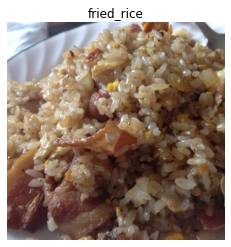

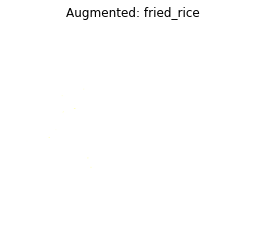

In [ ]:
# View random image and compare with its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

target_class = random.choice(train_data_1_percent.class_names)
target_folder = train_dir + target_class
target_image = random.choice(os.listdir(target_folder))
random_image = target_folder + "/" + target_image

# Read in the random image
img = mpimg.imread(random_image)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)

# Read in augmented image
augmented_image = data_augmentation(img, training = True)
plt.figure()
plt.imshow(augmented_image)
plt.title(f'Augmented: {target_class}')
plt.axis(False)

## Feature Extraction Transfer Learning On 1% Training Data

In [ ]:
# Setup input shape, base mode and freezing base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape = input_shape, name = "Input_Layer")

# Add in data augmentation sequential model as layer
x = data_augmentation(inputs)

# Give the base model th inputs (after augmentaion) and do not train
x = base_model(x, training = False)

# Pull out features of the base model
x = layers.GlobalAveragePooling2D(name = 'Pooling_Layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using input and output
model_1 = keras.Model(inputs, outputs)


# Compile he model
model_1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Fit the model 
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks = [create_tensorboard_callback(dirname = "transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

Saving Tensorboard log files to: transfer_learning/1_percent_data_aug/20220721-09071658395046
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4475 - accuracy: 0.0286 - val_loss: 2.2208 - val_accuracy: 0.1891
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1599 - accuracy: 0.2714 - val_loss: 2.0972 - val_accuracy: 0.2845
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9929 - accuracy: 0.4429 - val_loss: 1.9996 - val_accuracy: 0.3470
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8045 - accuracy: 0.5000 - val_loss: 1.9056 - val_accuracy: 0.3766
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6325 - accuracy: 0.6000 - val_loss: 1.8142 - val_accuracy: 0.4441


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, 3)          0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_Layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.8251 - accuracy: 0.4308


[1.8250925540924072, 0.4307999908924103]

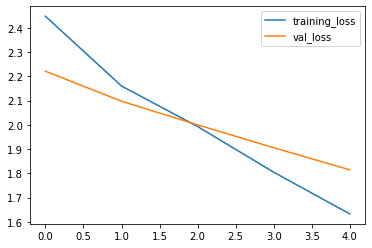

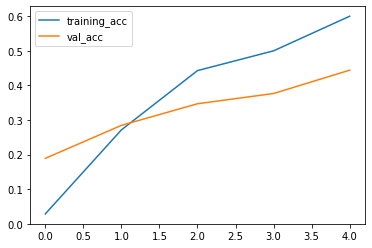

In [ ]:
model_curves(history_1_percent)

# Model_2: Feature Extraction Transfer Learning On 10% Of The Data With Data Augmentation

Since we already have the data loaded and ready, we wont need to repeat the process, we are just goint to make use of it directly.

In [ ]:
# Create model_2 with data augmentation built in
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
  # Since it is an EfficientNet model, it does not require normalization
], name = "data_augmentation")


#Setup the input shape
input_shape = (224, 224, 3)


# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


# Create the inputs and outputs (including layers in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = keras.Model(inputs, outputs)

#Compile
model_2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])



## Creating A Model ChecPoint Callback

The model checkpoint callback intermediately saves our model (the full mode or just the weights) during training. This makes us take a break and come back where we left it.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a model checkpoint calllback that saves only the model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                                         save_best_only = False,
                                                         save_weights_only = True,
                                                         save_freq = 'epoch',  #That is, save after every epoc
                                                         verbose = 1)



## Fit Model_2 and make use of the model checkpoint callback

In [ ]:
initial_epoch = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent, 
                                          epochs = initial_epoch,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback("transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])


Saving Tensorboard log files to: transfer_learning/10_percent_data_aug/20220721-09071658395091
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9960 - accuracy: 0.3560
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 19s 525ms/step - loss: 1.9960 - accuracy: 0.3560 - val_loss: 1.4979 - val_accuracy: 0.6332
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3449 - accuracy: 0.6933
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 10s 389ms/step - loss: 1.3449 - accuracy: 0.6933 - val_loss: 1.0717 - val_accuracy: 0.7434
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0506 - accuracy: 0.7400
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 9s 373ms/step - loss: 1.0506 - accuracy: 0.7400 - val_loss: 0.8596 - val_accuracy: 0.77

In [ ]:
# What are model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6040 - accuracy: 0.8404


[0.6040183901786804, 0.840399980545044]

In [ ]:
# Whata re model_2 results
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.6877 - accuracy: 0.8084


[0.6876658797264099, 0.8083999752998352]

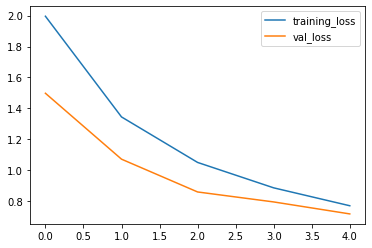

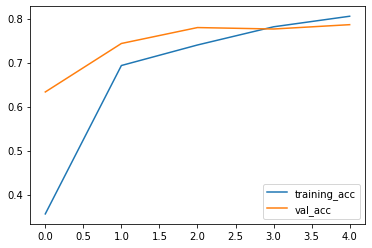

In [ ]:
# Plot model loss curves
model_curves(history_10_percent_data_aug)

In [ ]:
#Loading in the checkpointed wieghts
model_2.load_weights(checkpoint_path)

#Evaluate model_2 with loaded weights
loaded_wights_model_result = model_2.evaluate(test_data) # The values obtained (loss and accuracy) will be very close to the ones initially obtained before loading.


79/79 [==============================] - 6s 72ms/step - loss: 0.6877 - accuracy: 0.8084


# Model 3: Fine-tuning an existing model on 10% of the data


ðŸ”‘ Note: Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Checking the layers in model
model_2.layers



In [ ]:
# To check if layers were trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc2552fb9d0> True
<keras.engine.sequential.Sequential object at 0x7fc2552fb890> True
<keras.engine.functional.Functional object at 0x7fc254e01190> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc255340690> True
<keras.layers.core.dense.Dense object at 0x7fc254f2d950> True


In [ ]:
# What layers are in our base_model and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


**NB:** It is encouraged to unfreeze the last few layers of the base model whenever we are fine tuning because these layers are close to the dense/final layers of the entire model. At the beginning layers, the model is learning general patterns while towards the end, it begins to learn specific patterns peculiar to the different classes. This makes it perform well in understanding these specific feature.


In [ ]:
# To begin fine-tuning, let us set the last 10 layers of our base model to to be trainable (base_model.trainable = True)
base_model.trainable = True

# Freeze all other layers apart from the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile. We have to recompile our model everytime we make a change
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), # When fine tuning, you want to lower the learning rate by 10x* 
                metrics =["accuracy"])

ðŸ”‘ **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Check the layers that are now trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
len(model_2.trainable_variables)

12

In [ ]:
# Fine tune for another 5 epoch
fine_tuning_epochs = initial_epoch + 5

# Refit the model. It is the same as in model_2 but with more trainable layers.
history_fine_tune_10_percent_data_aug = model_2.fit(train_data_10_percent, 
                                                    epochs = fine_tuning_epochs,
                                                    steps_per_epoch = len(train_data_10_percent),
                                                    validation_data = test_data,
                                                    validation_steps = int(0.25 *len(test_data)),
                                                    initial_epoch = history_10_percent_data_aug.epoch[-1], #Start training from last epoch
                                                    callbacks = [create_tensorboard_callback(dirname = "transfer_learning",
                                                                                             experiment_name = "10_percent_fine_tune_last_10")])

Saving Tensorboard log files to: transfer_learning/10_percent_fine_tune_last_10/20220721-09071658395183
Epoch 5/10
24/24 [==============================] - 21s 582ms/step - loss: 0.8057 - accuracy: 0.7253 - val_loss: 0.5516 - val_accuracy: 0.8289
Epoch 6/10
24/24 [==============================] - 9s 374ms/step - loss: 0.4370 - accuracy: 0.8493 - val_loss: 0.5972 - val_accuracy: 0.8059
Epoch 7/10
24/24 [==============================] - 8s 307ms/step - loss: 0.2887 - accuracy: 0.9067 - val_loss: 0.5849 - val_accuracy: 0.8043
Epoch 8/10
24/24 [==============================] - 8s 340ms/step - loss: 0.1694 - accuracy: 0.9547 - val_loss: 0.6160 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 8s 325ms/step - loss: 0.1545 - accuracy: 0.9520 - val_loss: 0.5874 - val_accuracy: 0.8240
Epoch 10/10
24/24 [==============================] - 8s 300ms/step - loss: 0.1006 - accuracy: 0.9733 - val_loss: 0.7182 - val_accuracy: 0.8026


In [ ]:
# Evaluate the fine tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6191 - accuracy: 0.8240


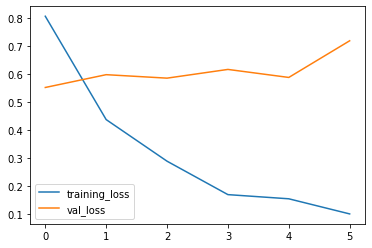

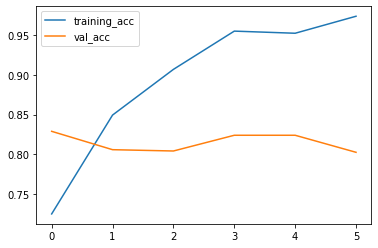

In [ ]:
model_curves(history_fine_tune_10_percent_data_aug)

The plot_loss_curves function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (e.g. before and after fine-tuning).

In [ ]:
def compare_history(original_history, new_history, initial_epoch):
  # Get original history
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]


  # Combine original history metric with new history metric
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]


  # Make Plot for accuracy
  plt.figure(figsize  =(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Val accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label = "Start fine tuning")
  plt.legend(loc = "upper right")
  plt.title("Training And validation Accuracy")


  # Make Plot for loss
  plt.figure(figsize  =(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label = "Start fine tuning")
  plt.legend(loc = "upper right")
  plt.title("Training And validation Loss")

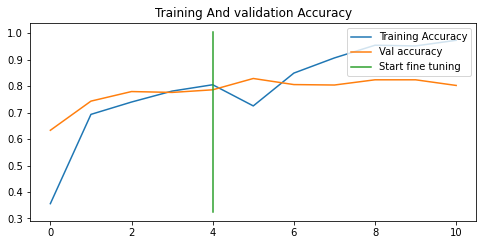

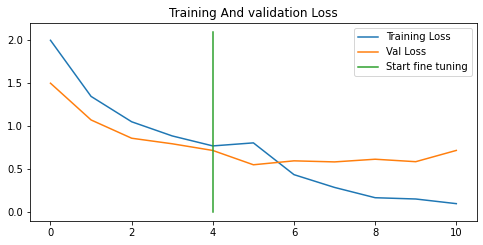

In [ ]:
compare_history(original_history = history_10_percent_data_aug,
                new_history = history_fine_tune_10_percent_data_aug,
                initial_epoch = 5)

# Model_4: Fine Tuning An Existing Model On 100% Of The Data

- Load the data
- Get training and testing set ready
- Evaluate saved model 2 on new test data
- Fine tune the saved model 2 to obtain model 4
- Train model 4 on new train data and evaluate on test data
- Plot all that is going on


## Loading The Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-07-21 09:21:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 142.250.125.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: â€˜10_food_classes_all_data.zipâ€™

10_food_classes_all 100%[===================>] 495.13M   329MB/s    in 1.5s    

2022-07-21 09:21:02 (329 MB/s) - â€˜10_food_classes_all_data.zipâ€™ saved [519183241/519183241]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirpath, dirname, filename in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/train
There are 0 directories and 750 images in 10_food_classes_all_data/train/ramen
There are 0 directories and 750 images in 10_food_classes_all_data/train/hamburger
There are 0 directories and 750 images in 10_food_classes_all_data/train/fried_rice
There are 0 directories and 750 images in 10_food_classes_all_data/train/sushi
There are 0 directories and 750 images in 10_food_classes_all_data/train/steak
There are 0 directories and 750 images in 10_food_classes_all_data/train/ice_cream
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_wings
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_curry
There are 0 directories and 750 images in 10_food_classes_all_data/train/grilled_salmon
There are 0 directories and 750 images in 10_food_classes_all_data/train/pizza
There are 10 directories and 0 imag

## Get The Train And Test Sets Ready

In [ ]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

train_data = image_dataset_from_directory(train_dir, 
                                          label_mode = "categorical",
                                          batch_size = BATCH_SIZE,
                                          image_size = (224, 224))

test_data = image_dataset_from_directory(test_dir,
                                         label_mode = "categorical",
                                         batch_size = BATCH_SIZE,
                                         image_size = (224, 224))

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Evaluate saved model 2 on new test data

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6191 - accuracy: 0.8240


[0.6191065311431885, 0.8240000009536743]

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)


79/79 [==============================] - 6s 71ms/step - loss: 0.6877 - accuracy: 0.8084


[0.6876658797264099, 0.8083999752998352]

## Fine tune the loaded model 2 to obtain model 4

In [ ]:
for i, layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 pooling_layer True
4 output_layer True


In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Recompile the model

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

# Train the model
fine_tune_epochs = initial_epoch + 5
history = model_2.fit(train_data,
                      epochs = fine_tune_epochs,
                      steps_per_epoch = len(train_data),                  
                      validation_data  = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      initial_epoch = history_10_percent_data_aug.epoch[-1], #Start training from last epoch
                                                    callbacks = [create_tensorboard_callback(dirname = "transfer_learning",
                                                                                             experiment_name = "all_data_experiment")])

Saving Tensorboard log files to: transfer_learning/all_data_experiment/20220721-09071658395285
Epoch 5/10
235/235 [==============================] - 57s 216ms/step - loss: 0.7331 - accuracy: 0.7644 - val_loss: 0.4310 - val_accuracy: 0.8520
Epoch 6/10
235/235 [==============================] - 47s 199ms/step - loss: 0.5893 - accuracy: 0.8093 - val_loss: 0.3676 - val_accuracy: 0.8783
Epoch 7/10
235/235 [==============================] - 43s 181ms/step - loss: 0.5305 - accuracy: 0.8252 - val_loss: 0.3917 - val_accuracy: 0.8750
Epoch 8/10
235/235 [==============================] - 42s 177ms/step - loss: 0.4819 - accuracy: 0.8433 - val_loss: 0.3620 - val_accuracy: 0.8914
Epoch 9/10
235/235 [==============================] - 37s 156ms/step - loss: 0.4459 - accuracy: 0.8572 - val_loss: 0.2910 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 37s 155ms/step - loss: 0.4198 - accuracy: 0.8653 - val_loss: 0.3288 - val_accuracy: 0.9095


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.3177 - accuracy: 0.8984


[0.31772491335868835, 0.8984000086784363]

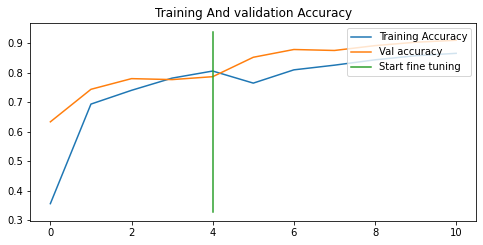

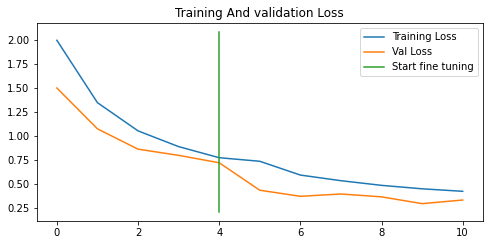

In [ ]:
compare_history(original_history= history_10_percent_data_aug,
                new_history = history,
                initial_epoch = 5)

# Comparing Our Model's Results Using TensorBoard

In [ ]:
# Upload TensorBoard dev record
'''!tensorboard dev upload --logdir ./transfer_learning/ \
  --name "Transfer Learning Experiment"\
  --description "Various models built on the same data but different proportions"\
  --one_shot''' 

'!tensorboard dev upload --logdir ./transfer_learning/   --name "Transfer Learning Experiment"  --description "Various models built on the same data but different proportions"  --one_shot'

# **Exercise**

Wrtie a function that could print image from random data_dir and class

In [ ]:
import random

def random_image(dirs, classes):
  data_dir = random.choice(dirs)
  class_name = random.choice(classes)
  path = data_dir + class_name
  random_file = random.choice(os.listdir(path))
  actual_image = path + "/" + random_file
  

  img = mpimg.imread(actual_image)
  plt.imshow(img)
  plt.title(print(f"This is a {class_name} from images in {data_dir}"))
  plt.axis(False)

This is a sushi from images in 10_food_classes_all_data/train/


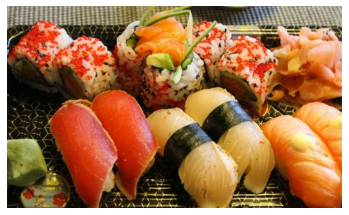

In [ ]:
directories = [train_dir, test_dir]
classes_ = random.choice(train_data.class_names)


random_image(dirs = directories,
             classes = train_data.class_names)

class_names = train_data.class_names

## Load Custom Data And Use Model To Predict Them

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg       
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg 

--2022-07-21 09:26:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: â€˜03-hamburger.jpegâ€™

03-hamburger.jpeg   100%[===================>]   3.40M  --.-KB/s    in 0.07s   

2022-07-21 09:26:38 (47.1 MB/s) - â€˜03-hamburger.jpegâ€™ saved [3564285/3564285]

--2022-07-21 09:26:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, 

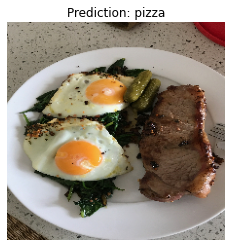

In [ ]:
# Load and preprocessing custom image 

def load_and_prep_image(filename):
  # Read in the image
  img = tf.io.read_file(filename)

  # Convert to tensors
  img = tf.image.decode_image(img)

  # Resize the image
  img = tf.image.resize(img, size = [224, 224])

  # Normalize image
  img = img/255.

  return img



def pred_and_plot(filename, model, classes):

  img = load_and_prep_image(filename) # Alredy built function to laod custom images and preprocess them 

  prediction = model.predict(tf.expand_dims(img, axis = 0))                 # Making prediction on our custom image using the model we built
  if len(prediction[0]) > 1:                                                # Since we want it to work for binary and multiclass classififcation tasks
    pred_class = classes[prediction.argmax()]                               # Picking the maximum prediction prob. provided for Multi class
  else:
    pred_class = classes[int(tf.round(prediction)[0][0])]                          # Approximating the pred prob given in binary classification

  # Visualizing our image
  plt.imshow(img) 
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)


pred_and_plot(filename = "03-steak.jpeg",
              model = model_2,
              classes = class_names)

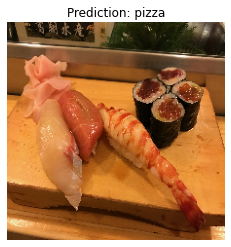

In [ ]:
pred_and_plot(filename = "03-sushi.jpeg",
              model = model_2,
              classes = class_names)

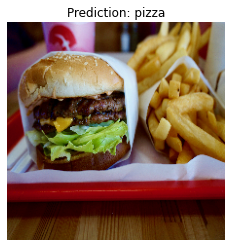

In [ ]:
pred_and_plot(filename = "03-hamburger.jpeg",
              model = model_2,
              classes = class_names)

In [ ]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
len(train_data.class_names)

10

In [ ]:
s = "03-sushi.jpeg"
dara = load_and_prep_image(s)

pred = model_2.predict(tf.expand_dims(dara, axis = 0))
pred = pred.argmax()
class_names[pred]

'pizza'